# Regression: Predict Allstate Claims Severity

## Fire up Packages

In [1]:
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
from sklearn.cross_validation import train_test_split
import numpy

## Load Training Data

In [2]:
train = pandas.read_csv('train.csv')
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [3]:
del train['id']

## Briefly explore the response variable

**As we have a high dimensional dataset, feature engineering will be quite time consuming if I check the covariate one by one. Therefore, I first focus on exploring the response variable. If neccessary I will implement PCA to reduce the dimension of dataset and compare the results.**

In [4]:
training,testing = train_test_split(train,test_size=0.2,random_state=42)
print training.shape
print testing.shape

(150654, 131)
(37664, 131)


In [5]:
Response= training['loss']

**1. See the mean, sd and median of response variable**

In [6]:
print 'Mean of Response Variable'+' '+'is'+' '+ str(numpy.mean(Response))
print 'Median of Response Variable'+' '+'is'+' '+ str(numpy.median(Response))
print 'Standard Deviation of Response Variable'+' '+'is'+' '+ str(numpy.std(Response))

Mean of Response Variable is 3039.63159604
Median of Response Variable is 2115.895
Standard Deviation of Response Variable is 2915.84711509


**2:Check whether the response variable is normally distributed**

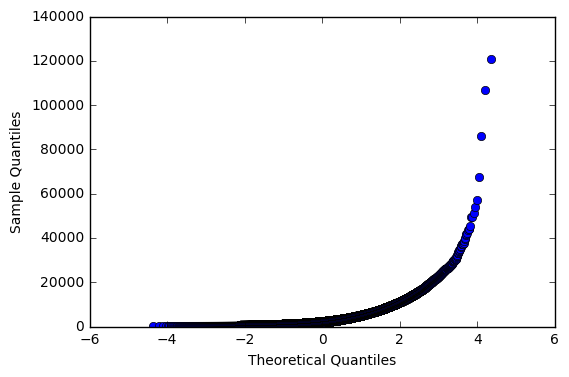

In [7]:
import statsmodels.api as sm
fig=sm.qqplot(Response)

**We can see that the normality of response variable is quite bad. The response variable seems to be exponentially distributed. Therefore, we transform it into the logrithm form and replot the qq-plot.**

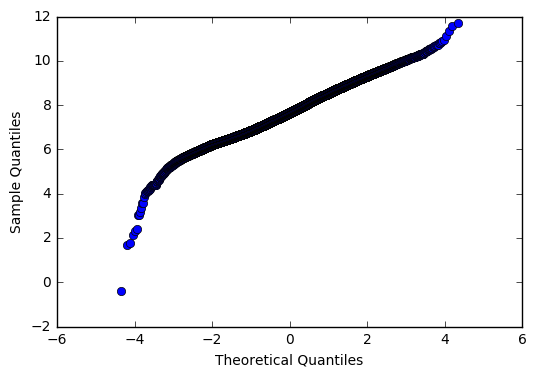

In [8]:
training=training.reset_index(drop=True)
testing = testing.reset_index(drop=True)
training['logloss']=numpy.log(training['loss'])
fig2=sm.qqplot(training['logloss'])

**The noramlity of the logthrim response variable is not bad. So we set it as the new lable.**

## Convert categorical variables and process real test data

In [9]:
features = training.columns
cat_feature=list(features[0:116])
test=pandas.read_csv('test.csv')
for each in cat_feature:
    training[each]=pandas.factorize(training[each], sort=True)[0]
    testing[each]=pandas.factorize(testing[each],sort=True)[0]
    test[each]=pandas.factorize(test[each],sort=True)[0]

## Preliminary model selection: try five different regressors at first##

In [11]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
Predictors= training.ix[:,0:130]
Predictors_test= testing.ix[:,0:130]

In [17]:
Regressors = [LinearRegression(),RandomForestRegressor(n_estimators=200),Lasso(),DecisionTreeRegressor(),GradientBoostingRegressor(learning_rate=0.3)]
MAE=[]
Model_Name=[]
for reg in Regressors:
    Model=reg.fit(Predictors,training['logloss'])
    Prediction= numpy.exp(Model.predict(Predictors_test))
    eva = mae(testing['loss'],Prediction)
    MAE.append(eva)
    Name=reg.__class__.__name__
    Model_Name.append(Name)
    print 'Accuracy of'+ ' '+Name+' '+'is'+' '+str(eva)

Accuracy of LinearRegression is 1283.91190791
Accuracy of RandomForestRegressor is 1212.42750158
Accuracy of Lasso is 1775.44117566
Accuracy of DecisionTreeRegressor is 1731.64854922
Accuracy of GradientBoostingRegressor is 1183.90923254


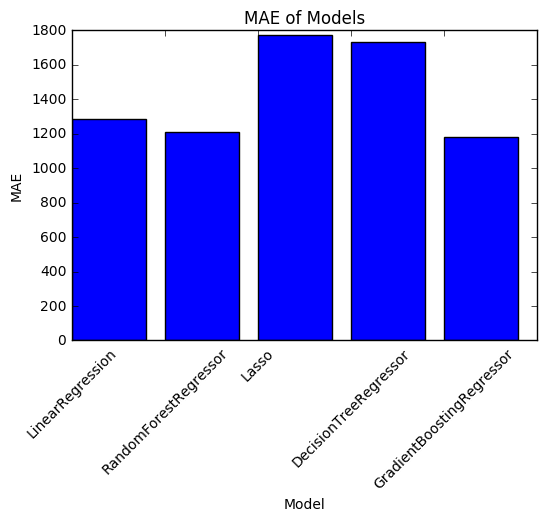

In [20]:
Index = [1,2,3,4,5]
plt.bar(Index,MAE)
plt.xticks(Index, Model_Name,rotation=45)
plt.ylabel('MAE')
plt.xlabel('Model')
plt.title('MAE of Models')

**We can see that the ensembled models are better than the other three models. Therefore, I will try to focus on parameter tuning of Gradient Boosting Model in order to obtain a better result**

## Parameter tuning for Gradient Boosting Model

**Rule of thumb: Try to balance the learning rate and model complexity. Avoid overfitting to the greatest extent while not jeopardizing the advantage of model. I will try different factors while keep the number of estimators fixed as default (100).**

In [22]:
#from sklearn.grid_search import GridSearchCV

In [ ]:
#gb=GradientBoostingRegressor()
#param_grid={
 #   'learning_rate':[0.3,0.5,0.7],
 #   'max_depth':[3,5,7],
 #  'max_features': ['auto', 'sqrt', 'log2']
#}
#CV_GB = GridSearchCV(estimator=gb, param_grid=param_grid, cv= 3)
#CV_GB.fit(Predictors,training['logloss'])

In [ ]:
#print CV_GB.best_params_

In [22]:
gb=GradientBoostingRegressor(learning_rate=0.35,max_depth=6)
Model= gb.fit(Predictors,training['logloss'])
Prediction= numpy.exp(Model.predict(Predictors_test))
eva = mae(testing['loss'],Prediction)
print eva

1183.49825578


## Retrain the model and generate the output file

In [37]:
#features=Predictors.columns
#train['logloss']=numpy.log(train['loss'])
#for each in cat_feature:
    #train[each]=pandas.factorize(train[each], sort=True)[0]
#Model_f=gb.fit(train[features],train['logloss'])
#Prediction_F=numpy.exp(Model_f.predict(test[features]))

In [34]:
submission = pandas.read_csv('sub.csv')
submission.iloc[:, 1] = Prediction_F
submission.to_csv('sub.csv', index=None)